![alt text](samples.jpg)
[https://www.iosb.fraunhofer.de/servlet/is/78045/samples.jpg](https://www.iosb.fraunhofer.de/servlet/is/78045/samples.jpg)

# Classifying Logos in Images with Convolutionary Neural Networks

### Why should you read about machine learning and in particular this post?

The father of artificial intelligence (AI), John McCarthy, called AI "the science and engineering of making intelligent machines". Machine learning is the part of AI that is nowadays already reality. Here computers learn like humans from experience (= data) instead of being explicitly programmed.

As more and more data is available on which today's powerful computers can be trained, machine learning is now used everywhere: From customized video recommendations, image and speech recognition in medical research, spam and fraud detection, stock market analysis and video games to self-driving cars.

As a follow-up on [our review of the first term of Udacity's Machine Learning Engineer Nanodegree](https://medium.com/twodigits/https-medium-com-ajuschka-the-first-term-of-udacitys-machine-learning-engineer-nanodegree-592f14b586c), this blog post explains in detail how in our final deep learning project of the second term we implement Convolutional Neural Networks with Python's library Keras in order to classify logos in images. We are also interested in this topic as we later wish to analyze sentiments in twitter tweets with pictures where a given company's logo is detected.

---

### 1.  What image data do we use to train our Convolutional Neural Network?

Finding an interesting dataset is always the first step for any machine learning problem. Suited for our later purpose of classifying logos in arbitrary images from twitter tweets, we get access to the large [Logos in the Wild Dataset](https://www.iosb.fraunhofer.de/servlet/is/78045/) with 11,052 images containing different logo classes. Instead of downloading the images from the URLs provided with this dataset, we get 9,428 of them as a subset of the [QMUL-OpenLogo Dataset](https://www.iosb.fraunhofer.de/servlet/is/78045/). First, we load the images and label them with the target brand given by the corresponding folder name:

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy 

#load files from LogosInTheWild directory with logo categories given by their subfolder name
data = load_files('LogosInTheWild-v2/data/voc_format')
logo_files = numpy.array(data['filenames'])
jpg_indices = [index for index, name in enumerate(logo_files) if 'jpg'==name.split('.')[-1]]
logo_targets = np_utils.to_categorical(numpy.array(data['target']), max(data['target']+1))
all_files, all_targets = logo_files[jpg_indices], logo_targets[jpg_indices]

Using TensorFlow backend.


After each training step, it makes sense to validate the resulting parameters and machine learning algorithm on a separate subset of the image files, the *validation set*. We define a *checkpointer* that saves the weight parameters with the best result on this validation set. In the end, after finishing the whole training process we want to test our machine learning algorithm on another separate subset, the *test set*. Thus we split our image dataset into training, validation and test set, and define the checkpointer  as follows:

In [2]:
from sklearn.model_selection import train_test_split

#split into 80% training+validation files+labels, and 20 % test files+labels
train_and_val_files, test_files, train_and_val_targets, test_targets = train_test_split(all_files, all_targets, test_size=0.2, random_state=0)
#further split into 80% training files+labels, and 20 % validation files+labels
train_files, val_files, train_targets, val_targets = train_test_split(train_and_val_files, train_and_val_targets, test_size=0.2, random_state=0)
        
#create a checkpointer to save the CNN model with the best weight parameters
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_keras_models/weights.best.CNN.hdf5', 
                               save_best_only=True)

As last preprocessing step, for Keras' Convolutional Neural Networks we convert each image to 224 x 224 pixels with the 3 RGB channels red, green and blue in order to interpret the 6,033  training, 1,509 validation and 1,886 test image files as three *4D tensors* with respective  shape (number of images, 224, 224, 3).

In [3]:
from keras.preprocessing import image                  
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

def path_to_tensor(img_path):
    # loads RGB image as PIL format with 224x224 pixels
    img = image.load_img(img_path, target_size=(224, 224))
    # convert to 3D tensor with shape (224, 224, 3) with 3 RGB channels
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return it
    return numpy.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    #stack the (1,224,224,3) 4D tensor arrays to a (# images,224,224,3) 4D tensor
    return numpy.vstack(list_of_tensors)

#create 4D tensors and rescale each pixel by dividing by RGB max value 255
train_tensors = paths_to_tensor(train_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

---

### 2. Why & how to use Convolutional Neural Networks for our logo classification problem?

In the second step, we decide which machine learning algorithm we want to use. As CNNs are a specific type of neural networks that are used most commonly for analyzing images, let us first display a simple *neural network*:

![alt text](neuralnetwork.png)

Roughly speaking, a neural network is a graph consisting of one *input layer*, *hidden layers* and one *output layer* whose *nodes* are connected with each other. Here our inputs are the features of our input data, e.g., the RGB values of each single pixel of our images. The output nodes correspond to the possible logo classes in our dataset. The  connecting edges have different importance given by their *weight values*, and the output of any node is computed by applying an [activation function](https://en.wikipedia.org/wiki/Activation_function), like the ones below, to the weighted sum of its respective input values.

![alt text](activationfunctions.png "The activation functions ReLU and Softmax in case of two input values (for others, see https://en.wikipedia.org/wiki/Activation_function)")

While we will use the [Rectified linear unit (ReLU) activation](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for hidden layers, the [Softmax activation](https://en.wikipedia.org/wiki/Softmax_function) is used for the output layer to obtain a probability in the interval [0,1] for each output node. When "training the neural network", the computer itself repeatedly *optimizes* the weights of the edges so that the neural network's output becomes as close as possible to the true logo classes.

When analyzing images, the amount of parameters in a classical neural net becomes very large: If an image measures 224 x 224 pixels and we record for each pixel its 3 RGB values as input, then we have 224 x 224 x 3 = 150,528 input nodes so that the neural net needs to optimize a large amount of weight parameters for all fully connecting edges. Further, the input nodes are arranged as a vector so the neural net does not know any regional patters of the image. These problems motivate *Convolutional Neural Nets* like this one:

![alt text](cnn4.PNG)

In our example, the input nodes of the CNN are arranged in a 4x4 matrix shape. Then we define three 2x2 filters for the four input regions, where each region is  only connected with the three correspondingly colored nodes in the hidden layer. Note that the 3 filters define 3 *feature maps*, which each detects a feature like a vertical, horizontal or diagonal line in the four regions. Or, in our use case, such a feature may be detecting a Starbucks, Burger King or Telekom logo.

As the weights parameters for the connections from the input layer to the convolutional layer are  the same for each of the three filter, here we have only 2 x 2 x 3 = 12 weight parameters to be optimized in the training process thanks to fewer connecting edges and the CNN "understands" the regional contributions of the input data. Of course, in addition the training process optimizes the 12 x 9 = 108 weight parameters for the final fully connected output layer.

With respect to our concrete example of classifying small logos in images, a further advantage of CNNs is that they are translation invariant, i.e., they recognize logos in any region of the image.

---

### 3. Training a Convolutional Neural Net for Classifying Logos in Keras

We are almost ready to define our own CNN architecture from scratch. For doing so, next to convolutional layers defined above, we also make use of  *pooling layers*. There are two common types that both reduce the dimensions of the feature maps: max pooling and global average pooling layers.

![alt text](maxpoolinglayer.PNG "Max pooling layer with 2x2 pool size and two feature maps")

A *max pooling layer* maps a *pooling window* in a feature map to its maximal value. E.g., the two green 2x2 pooling windows in the two feature maps on the left hand side are mapped to their respective maximal values 0.6 and 0.7 in the max pooling layer on the right hand side. We note that the dimension of the feature maps got reduced by 2.

![alt text](globalaveragepoolinglayer.PNG "Global average pooling layer with two feature maps")

Similarly, a *global average pooling layer* maps each feature map to the average value of the values of its nodes. E.g., the average values for the blue feature map on the right hand side is -0.1 – 0.2 – 0.4 – 0.1 = -0.2. Here we point out that the resulting feature maps consist of a single node so *global* average pooling layers reduce the dimension drastically.

Now we are ready to define our CNN architecture as follows:

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

cnn_model = Sequential()

#after the input layer, add the first convolutional layer with 32 2x2-filters 
cnn_model.add(Conv2D (kernel_size = (2,2), filters = 32, 
                      input_shape=train_tensors.shape[1:], activation='relu'))
#add a max pooling layer with a 2x2 pooling window
cnn_model.add(MaxPooling2D(pool_size=2))
#add the second convolutional layer with 64 2x2-filters 
cnn_model.add(Conv2D(kernel_size = 2, filters = 64, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
#add the third convolutional layer with 128 2x2-filters 
cnn_model.add(Conv2D(kernel_size = 2, filters = 128, activation='relu'))
#add a dropout layer so that each node has a chance of 20% to be dropped when training
cnn_model.add(Dropout(rate = 0.2))
cnn_model.add(MaxPooling2D(pool_size = 2))
#add a global average pooling layer
cnn_model.add(GlobalAveragePooling2D())
#add the final fully connected output layer with 109 node for all 109 logo classes
cnn_model.add(Dense(109, activation = 'softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 110, 110, 64)      8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 54, 54, 128)       32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 54, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 128)       0         
__________

Finally, we are ready to train our CNN model. For this, we choose a specific type of optimization algorithm called [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) as error function for calculating how close we are to the true logo classes, and the standard metric *accuracy* = number of correct prediction/number of all predictions.

In [15]:
#Compile the model 
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model for 600 epochs
H = cnn_model.fit(train_tensors, train_targets, epochs=100, verbose=1,  
                  validation_data=(val_tensors, val_targets), callbacks=[checkpointer])

#After training, load the model with the minimal error on the validation set
cnn_model.load_weights('saved_keras_models/weights.best.CNN.hdf5')

Train on 6033 samples, validate on 1509 samples
Epoch 1/100
6033/6033 [==============================] - 543s 90ms/step - loss: 4.3714 - acc: 0.0590 - val_loss: 4.2234 - val_acc: 0.0762

Epoch 00001: val_loss did not improve from 3.14239
Epoch 2/100
6033/6033 [==============================] - 542s 90ms/step - loss: 4.1184 - acc: 0.0847 - val_loss: 4.0665 - val_acc: 0.1001

Epoch 00002: val_loss did not improve from 3.14239
Epoch 3/100
6033/6033 [==============================] - 541s 90ms/step - loss: 3.9657 - acc: 0.1076 - val_loss: 3.9738 - val_acc: 0.1067

Epoch 00003: val_loss did not improve from 3.14239
Epoch 4/100
6033/6033 [==============================] - 541s 90ms/step - loss: 3.8484 - acc: 0.1233 - val_loss: 3.8882 - val_acc: 0.1292

Epoch 00004: val_loss did not improve from 3.14239
Epoch 5/100
6033/6033 [==============================] - 542s 90ms/step - loss: 3.7730 - acc: 0.1372 - val_loss: 3.7978 - val_acc: 0.1292

Epoch 00005: val_loss did not improve from 3.14239
Ep

6033/6033 [==============================] - 539s 89ms/step - loss: 2.7128 - acc: 0.3247 - val_loss: 3.1012 - val_acc: 0.2783

Epoch 00042: val_loss did not improve from 3.07933
Epoch 43/100
6033/6033 [==============================] - 538s 89ms/step - loss: 2.6889 - acc: 0.3338 - val_loss: 3.0563 - val_acc: 0.2836

Epoch 00043: val_loss improved from 3.07933 to 3.05627, saving model to saved_keras_models/weights.best.CNN.hdf5
Epoch 44/100
6033/6033 [==============================] - 538s 89ms/step - loss: 2.6684 - acc: 0.3406 - val_loss: 3.0857 - val_acc: 0.2823

Epoch 00044: val_loss did not improve from 3.05627
Epoch 45/100
6033/6033 [==============================] - 539s 89ms/step - loss: 2.6647 - acc: 0.3368 - val_loss: 3.0586 - val_acc: 0.2830

Epoch 00045: val_loss did not improve from 3.05627
Epoch 46/100
6033/6033 [==============================] - 538s 89ms/step - loss: 2.6465 - acc: 0.3347 - val_loss: 3.0992 - val_acc: 0.2783

Epoch 00046: val_loss did not improve from 3.05


Epoch 00082: val_loss did not improve from 2.96602
Epoch 83/100
6033/6033 [==============================] - 538s 89ms/step - loss: 2.2072 - acc: 0.4315 - val_loss: 3.0082 - val_acc: 0.3188

Epoch 00083: val_loss did not improve from 2.96602
Epoch 84/100
6033/6033 [==============================] - 537s 89ms/step - loss: 2.1992 - acc: 0.4308 - val_loss: 2.9929 - val_acc: 0.3313

Epoch 00084: val_loss did not improve from 2.96602
Epoch 85/100
6033/6033 [==============================] - 541s 90ms/step - loss: 2.2003 - acc: 0.4339 - val_loss: 3.0187 - val_acc: 0.3214

Epoch 00085: val_loss did not improve from 2.96602
Epoch 86/100
6033/6033 [==============================] - 537s 89ms/step - loss: 2.1823 - acc: 0.4359 - val_loss: 3.0273 - val_acc: 0.3188

Epoch 00086: val_loss did not improve from 2.96602
Epoch 87/100
6033/6033 [==============================] - 537s 89ms/step - loss: 2.1789 - acc: 0.4381 - val_loss: 2.9786 - val_acc: 0.3327

Epoch 00087: val_loss did not improve from 2

---

### 4. Evaluating our trained CNN model

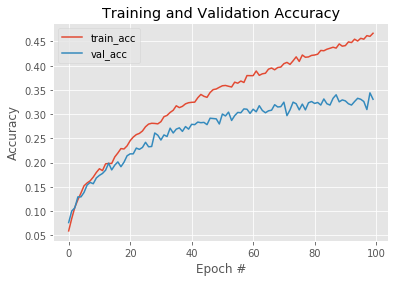

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,100),H.history["acc"],label="train_acc")
plt.plot(numpy.arange(0,100),H.history["val_acc"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

After training, we make use of Python's library *Matplotlib* to plot how our chosen metric accuracy develops over training epochs. We notice that while the accuracy, computed on the training set after each epoch, keeps increasing, the accuracy computed on the validation set remains more or less around 30%. So even though we added a [dropout layer](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) after the convolutionary layer with the largest number of parameters to reduce the chance of *overfitting*, this seems to happen. That is, our CNN model tends to memorize our training data so that its predictions on unseen data, in this case the validation set, is not that good.

Thus it would make sense to now collect more training data or finetune some parameters like learning rate, activation function, or number of nodes and filters used in our architecture. However, for our capstone project we did not achieve much better results than this, so due to space limits we skip the finetuning step here.
Finally, we check which accuracy our CNN model achieves on the test set:



In [20]:
print('\n', 'Test accuracy of our CNN model:', cnn_model.evaluate(test_tensors, test_targets, verbose=0)[1]*100,'%.')


 Test accuracy of our CNN model: 31.17709438912057 %.


---

### 5. Predicting Logo classes with our trained CNN

Having successfully trained our CNN model, we are ready to predict some logo classes using Keras' function *predict_classses*:

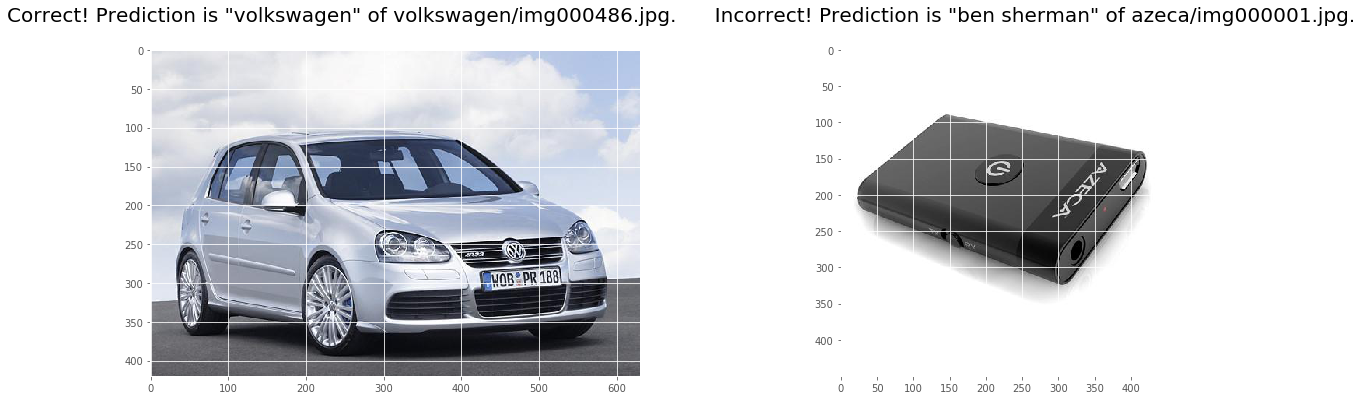

In [38]:
from glob import glob
import cv2
import matplotlib.pyplot as plt

# load list of brand names given by the subfolder names
brand_names = [item.split('/')[-2] for item in (glob("LogosInTheWild-v2/data/voc_format/*/"))]    
# get the brand name of the respective prediction of our CNN model for the respective test_tensor
brand_prediction1 = brand_names[cnn_model.predict_classes(numpy.expand_dims(test_tensors[267], axis=0))[0]]
brand_prediction2 = brand_names[cnn_model.predict_classes(numpy.expand_dims(test_tensors[266], axis=0))[0]]

#save the filenames
filename1=test_files[267].split('/')[-2]+'/'+test_files[267].split('/')[-1]
filename2=test_files[266].split('/')[-2]+'/'+test_files[266].split('/')[-1]

# load the images for plotting
img1 = cv2.imread(test_files[267])
img2 = cv2.imread(test_files[266])
# convert BGR image to RGB for plotting
cv_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#begin plotting the two images
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
plt.imshow(cv_rgb1)
fig.add_subplot(1,2,2)
plt.imshow(cv_rgb2)
fig.suptitle('Correct! Prediction is \"'+brand_prediction1+'\" of '+filename1+'.      Incorrect! Prediction is \"'+brand_prediction2+'\" of '+filename2+'.', fontsize=20)
plt.show()

For more results on finetuning parameters and other neural network architectures that we developed for our logo classification capstone project, we refer the reader to [our submitted Jupyter notebook](https://github.com/TwoDigits/logo-classification-capstone-project/blob/master/logo_classification.ipynb) and [capstone project report](https://github.com/TwoDigits/logo-classification-capstone-project/blob/master/capstone_project_report.pdf) in [our Github repository](https://github.com/TwoDigits/logo-classification-capstone-project). There you also find instructions for using [Tensorflow's Object Detecting API](https://github.com/tensorflow/models/tree/master/research/object_detection) for Faster R-CNN models and this blog post as Jupyter notebook.